In [4]:
import os
import csv
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact
import time
import dask.dataframe as dd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

import


In [5]:
# Function to get the data from the csv files and return a dataframe
def csv_to_df(filepath):
    try:
        return pd.read_csv(filepath, sep=",")
    except pd.errors.ParserError:
        return pd.read_csv(filepath, sep=";")


passagierfrequenz_df = csv_to_df("../raw_data/csv-4.csv")
haltestelle_df = csv_to_df("../raw_data/haltestelle.csv")
haltepunkt_df = csv_to_df("../raw_data/haltepunkt.csv")

In [6]:
fahrzeiten_filenames = [
    filename
    for filename in os.listdir("../raw_data/fahrzeiten/")
    if filename.endswith(".csv")
]
fahrzeiten_head = pd.read_csv(
    "../raw_data/fahrzeiten/" + fahrzeiten_filenames[0], nrows=0
).columns


def get_fahrzeiten_dask_df(filename, columns=None):
    if columns is None:
        columns = fahrzeiten_head
    df = dd.read_csv("../raw_data/fahrzeiten/" + filename, usecols=columns)
    return df.compute()


fahrzeiten_dfs = {
    filename: get_fahrzeiten_dask_df(filename) for filename in fahrzeiten_filenames
}

In [7]:
# Create widgets
output = widgets.Output()
dropdown = widgets.Dropdown(
    options=fahrzeiten_filenames, layout=widgets.Layout(width="auto")
)
next_button = widgets.Button(description="Next")
prev_button = widgets.Button(description="Previous")
head_button = widgets.Button(description="Head")
tail_button = widgets.Button(description="Tail")
output = widgets.Output(layout=widgets.Layout(overflow_x="scroll"))

# Initialize index
index = [0]


# Event handlers for button clicks
def on_next_button_clicked(b):
    index[0] = (index[0] + 1) % len(fahrzeiten_filenames)
    dropdown.value = fahrzeiten_filenames[index[0]]


def on_prev_button_clicked(b):
    index[0] = (index[0] - 1) % len(fahrzeiten_filenames)
    dropdown.value = fahrzeiten_filenames[index[0]]


def on_head_button_clicked(b):
    with output:
        output.clear_output()
        display(fahrzeiten_dfs[dropdown.value].head())


def on_tail_button_clicked(b):
    with output:
        output.clear_output()
        display(fahrzeiten_dfs[dropdown.value].tail())


# Attach event handlers to buttons
next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)
head_button.on_click(on_head_button_clicked)
tail_button.on_click(on_tail_button_clicked)

title = widgets.HTML('<h2 style="text-align: center;">Fahrzeiten: SOLL und IST</h2>')
box_layout = widgets.Layout(display="flex", justify_content="center")
display(
    widgets.VBox(
        [
            title,
            widgets.HBox([dropdown], layout=box_layout),
            widgets.HBox(
                [head_button, prev_button, next_button, tail_button], layout=box_layout
            ),
            widgets.HBox([output], layout=box_layout),
        ],
        layout=box_layout,
    )
)

In [8]:
# Create a dictionary of your DataFrames
dfs = {
    "Haltepunkte_df": haltepunkt_df,
    "Haltestelle_df": haltestelle_df,
    "Passagierfrequenz_df": passagierfrequenz_df,
}
# Create widgets
output = widgets.Output()
dropdown = widgets.Dropdown(options=list(dfs.keys()))
head_button = widgets.Button(description="Head")
tail_button = widgets.Button(description="Tail")
describe_button = widgets.Button(description="Describe")
shape_button = widgets.Button(description="Shape")
isnull_button = widgets.Button(description="IsNull")
dtype_button = widgets.Button(description="Dtype")
output = widgets.Output()


# Event handlers for button clicks
def on_head_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].head())


def on_tail_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].tail())


def on_describe_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].describe())


def on_shape_button_clicked(b):
    with output:
        output.clear_output()
        print(dfs[dropdown.value].shape)


def on_isnull_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].isnull().sum())


def on_info_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].info())


def on_dtype_button_clicked(b):
    with output:
        output.clear_output()
        display(dfs[dropdown.value].dtypes)


# Attach event handlers to buttons
head_button.on_click(on_head_button_clicked)
tail_button.on_click(on_tail_button_clicked)
describe_button.on_click(on_describe_button_clicked)
shape_button.on_click(on_shape_button_clicked)
isnull_button.on_click(on_isnull_button_clicked)


title = widgets.HTML('<h2 style="text-align: center;">Other CSVs</h2>')
box_layout = widgets.Layout(display="flex", justify_content="center")
display(
    widgets.VBox(
        [
            title,
            widgets.HBox([dropdown], layout=box_layout),
            widgets.HBox(
                [
                    head_button,
                    tail_button,
                    describe_button,
                    shape_button,
                    isnull_button,
                    dtype_button,
                ],
                layout=box_layout,
            ),
            widgets.HBox([output], layout=box_layout),
        ],
        layout=box_layout,
    )
)

In [9]:
def create_bar_chart_missing_data(df_dict, save=False):
    missing_data_percentages = {
        df_name: df.isnull().mean().mean() * 100 for df_name, df in df_dict.items()
    }

    df_missing_data = pd.DataFrame(
        missing_data_percentages.items(),
        columns=["DataFrame", "Missing Data Percentage"],
    )

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x=df_missing_data["DataFrame"],
        y=df_missing_data["Missing Data Percentage"],
        order=df_missing_data["DataFrame"],
        ax=ax,
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Percentage of Missing Data in each DataFrame")
    plt.xlabel("DataFrame")
    plt.ylabel("Missing Data Percentage (%)")
    plt.grid(axis="y")

    if save:
        plt.savefig("../figures/exploration/missing_data.png", bbox_inches="tight")
        plt.close()

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


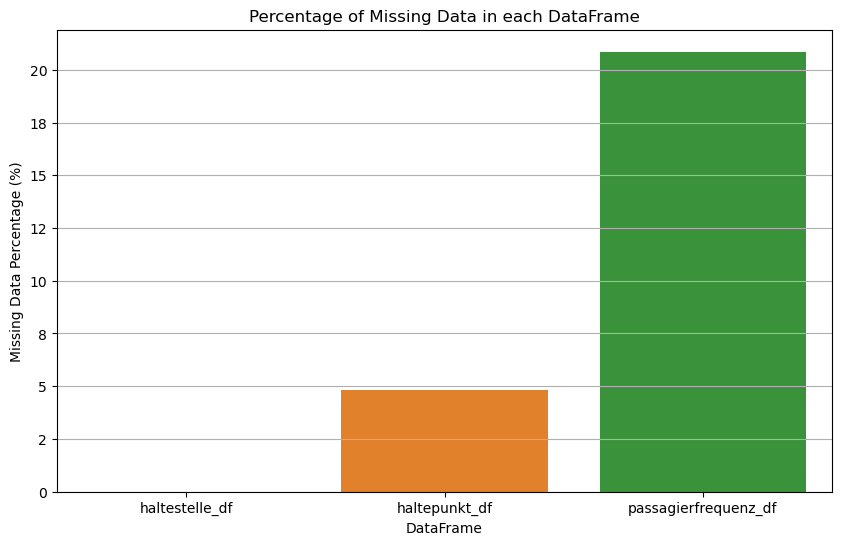

In [10]:
df_dict = {
    "haltestelle_df": haltestelle_df,
    "haltepunkt_df": haltepunkt_df,
    "passagierfrequenz_df": passagierfrequenz_df,
}

create_bar_chart_missing_data(df_dict)

In [11]:
display(haltestelle_df.dtypes)
display(haltepunkt_df.dtypes)
display(passagierfrequenz_df.dtypes)

halt_id            int64
halt_diva          int64
halt_kurz         object
halt_lang         object
halt_ist_aktiv      bool
dtype: object

halt_punkt_id             int64
halt_punkt_diva           int64
halt_id                   int64
GPS_Latitude            float64
GPS_Longitude           float64
GPS_Bearing             float64
halt_punkt_ist_aktiv       bool
dtype: object

code_codice               object
uic                      float64
bahnhof_gare_stazione     object
kt_ct_cantone             object
isb_gi                    object
jahr_annee_anno          float64
dtv_tjm_tgm              float64
dwv_tmjo_tfm             float64
dnwv_tmjno_tmgnl         float64
evu_ef_itf                object
bemerkungen               object
remarques                 object
note                      object
remarks                   object
geopos                    object
lod                       object
dtype: object

In [12]:
bemerkungen_df = passagierfrequenz_df["bemerkungen"].dropna()
remarks_df = passagierfrequenz_df["remarques"].dropna()
note_df = passagierfrequenz_df["note"].dropna()

display(bemerkungen_df)
display(remarks_df)
display(note_df)

2                                               Ohne TPC.
3                                               Ohne TPC.
6           Weniger als 50 Ein- und Aussteigende pro Tag.
18      Weniger als 50 Ein- und Aussteigende pro Nicht...
19          Weniger als 50 Ein- und Aussteigende pro Tag.
                              ...                        
2289                           Inklusive Bahnverkehr MVR.
2294        Weniger als 50 Ein- und Aussteigende pro Tag.
2296        Weniger als 50 Ein- und Aussteigende pro Tag.
2302                                            Ohne AVA.
2304    Durchschnittswert 2018 durch Streckensperrung ...
Name: bemerkungen, Length: 387, dtype: object

2                                               Sans TPC.
3                                               Sans TPC.
6                         Moins de 50 personnes par jour.
18              Moins de 50 personnes par jour non ouvré.
19                        Moins de 50 personnes par jour.
                              ...                        
2289                                   Trains MVR inclus.
2294                      Moins de 50 personnes par jour.
2296                      Moins de 50 personnes par jour.
2302                                            Sans AVA.
2304    Valeur moyenne 2018 à la baisse en raison de l...
Name: remarques, Length: 387, dtype: object

2                                              Senza TPC.
3                                              Senza TPC.
6                           Meno di 50 persone al giorno.
18           Meno di 50 persone al giorno non lavorativo.
19                          Meno di 50 persone al giorno.
                              ...                        
2289                                     Incl. treni MVR.
2294                        Meno di 50 persone al giorno.
2296                        Meno di 50 persone al giorno.
2302                                           Senza AVA.
2304    Valore medio 2018 compromesso dallo sbarrament...
Name: note, Length: 387, dtype: object

In [13]:
# Create widgets
output2 = widgets.Output()
dropdown2 = widgets.Dropdown(options=fahrzeiten_filenames)
describe_button = widgets.Button(description="Describe")
shape_button = widgets.Button(description="Shape")
isnull_button = widgets.Button(description="Is Null")
dtype_button = widgets.Button(description="Dtype")


# Event handlers for button clicks
def on_describe_button_clicked(b):
    with output2:
        output2.clear_output()
        display(fahrzeiten_dfs[dropdown2.value].describe())


def on_shape_button_clicked(b):
    with output2:
        output2.clear_output()
        print(fahrzeiten_dfs[dropdown2.value].shape)


def on_isnull_button_clicked(b):
    with output2:
        output2.clear_output()
        display(fahrzeiten_dfs[dropdown2.value].isnull().sum())


def on_dtype_button_clicked(b):
    with output2:
        output2.clear_output()
        if dropdown2.value in fahrzeiten_dfs:
            if not fahrzeiten_dfs[dropdown2.value].empty:
                display(fahrzeiten_dfs[dropdown2.value].dtypes)
            else:
                print("DataFrame is empty.")
        else:
            print("Key not found in dictionary.")


# Attach event handlers to buttons
describe_button.on_click(on_describe_button_clicked)
shape_button.on_click(on_shape_button_clicked)
isnull_button.on_click(on_isnull_button_clicked)

# Display widgets
title = widgets.HTML('<h2 style="text-align: center;">Fahrzeiten: SOLL und IST</h2>')
box_layout = widgets.Layout(display="flex", justify_content="center")
display(
    widgets.VBox(
        [
            title,
            widgets.HBox([dropdown2], layout=box_layout),
            widgets.HBox(
                [describe_button, shape_button, isnull_button, dtype_button],
                layout=box_layout,
            ),
            widgets.HBox([output2], layout=box_layout),
        ],
        layout=box_layout,
    )
)

In [14]:
def create_bar_chart_bahnhof_counts(df, save=False, values=10):
    bahnhof_counts = df["bahnhof_gare_stazione"].value_counts().to_dict()

    df_bahnhof_counts = pd.DataFrame(
        bahnhof_counts.items(), columns=["bahnhof_gare_stazione", "Count"]
    )

    if values > df_bahnhof_counts.shape[0]:
        values = df_bahnhof_counts.shape[0]

    df_bahnhof_counts = df_bahnhof_counts.sort_values("Count", ascending=False).head(
        values
    )

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x=df_bahnhof_counts["bahnhof_gare_stazione"],
        y=df_bahnhof_counts["Count"],
        order=df_bahnhof_counts["bahnhof_gare_stazione"],
        ax=ax,
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title(f"Top {values} Most Frequent bahnhof_gare_stazione")
    plt.xlabel("bahnhof_gare_stazione")
    plt.ylabel("Count")
    plt.grid(axis="y")

    if save:
        plt.savefig("../figures/exploration/bahnhof_count.png", bbox_inches="tight")
        plt.close()


# # Wie oft ist eine Linie in den fahrzeiten_dfs vorhanden
# def create_bar_chart_linien_counts(save=False, values=10):
#     linien_counts = {}

#     for df in fahrzeiten_dfs.values():
#         size = df.groupby('linie').size()
#         for linie, count in size.items():
#             if linie in linien_counts:
#                 linien_counts[linie] += count
#             else:
#                 linien_counts[linie] = count

#     df_linien_counts = pd.DataFrame(linien_counts.items(), columns=['Line', 'Count'])

#     if values > df_linien_counts.shape[0]:
#         values = df_linien_counts.shape[0]

#     df_linien_counts = df_linien_counts.sort_values('Count', ascending=False).head(values)

#     # Create the bar chart
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.barplot(x=df_linien_counts['Line'], y=df_linien_counts['Count'], order=df_linien_counts['Line'], ax=ax)
#     ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
#     plt.title(f'Top {values} Most Frequent Lines in Fahrzeiten CSVs')
#     plt.xlabel('Line')
#     plt.ylabel('Count')
#     plt.grid(axis='y')

#     if save:
#         plt.savefig('../figures/exploration/linien_count.png', bbox_inches='tight')
#         plt.close()

In [15]:
create_bar_chart_bahnhof_counts(passagierfrequenz_df, save=True, values=20)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


In [16]:
bahnhofe = passagierfrequenz_df["bahnhof_gare_stazione"].unique()

print(f"The unique 'bahnhof_gare_stazione' in the DataFrame are: {list(bahnhofe)}")

The unique 'bahnhof_gare_stazione' in the DataFrame are: ['Aathal', 'Aarburg-Oftringen', 'Aigle', 'Altstätten SG', 'Altendorf', 'Alvaneu', 'Arnegg', 'Arosa', 'Bäch', 'Boudry', 'Bernina Diavolezza', 'Bellinzona', 'Bellach', 'Belfaux CFF', 'Brügg BE', 'Biasca', 'Biel/Bienne Bözingenfeld/Champ', 'Bigenthal', 'Biberegg', 'Biel Mett', 'Birr', 'Biberist Ost', 'Blitzingen', 'Bern Stöckacker', 'Benzenschwil', 'Bôle', 'Boltigen', 'Boswil-Bünzen', 'Bouveret', 'Bowil', 'Belp Steinbach', 'Brusio', 'Brittnau-Wikon', 'Brunnadern-Neckertal', 'Brunnen', 'Brünig-Hasliberg', 'Basel SBB', 'Balsthal', 'Buchs SG', 'Bubikon', 'Buchrain', 'Beinwil am See', 'Buix', 'Bussigny', 'Bischofszell Stadt', 'Campascio', 'Castione-Arbedo', 'Cazis', 'Concise', 'Courchavon', 'Cadenazzo', 'Cavadürli', 'Montreux-Collège', 'Châtelard VD', 'Les Charbonnières', 'Chénens', 'Chernex', 'Châteauneuf-Conthey', 'Chiasso', 'La Chiésaz', "Château-d'Hauteville", 'Chur West', 'Cinuos-chel-Brail', 'Colombier', 'Colombier NE', 'Corgémont

In [17]:
betreiber = passagierfrequenz_df["isb_gi"].unique()

print(f"The unique 'isb_gi' in the DataFrame are: {list(betreiber)}")

The unique 'isb_gi' in the DataFrame are: ['SBB', 'RhB', 'BLS', 'SOB', 'MGB', 'ZB', 'OeBB', 'MOB', 'TRAVYS', 'MVR', 'BOB', 'STB']


In [18]:
def create_bar_chart_bahnhofseigner_counts(df, save=False):
    bahnhofseigner_counts = df["isb_gi"].value_counts().to_dict()

    df_bahnhofseigner_counts = pd.DataFrame(
        bahnhofseigner_counts.items(), columns=["Bahnhofseigner", "Number of Bahnhöfe"]
    )

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x=df_bahnhofseigner_counts["Bahnhofseigner"],
        y=df_bahnhofseigner_counts["Number of Bahnhöfe"],
        order=df_bahnhofseigner_counts["Bahnhofseigner"],
        ax=ax,
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Bahnhofseigner")
    plt.xlabel("Bahnhofseigner")
    plt.ylabel("Number of Bahnhöfe")
    plt.grid(axis="y")

    if save:
        plt.savefig(
            "../figures/exploration/bahnhofseigner_count.png", bbox_inches="tight"
        )
        plt.close()


# # Wie oft ist eine Stadt in den fahrzeiten_dfs vorhanden


# def create_bar_chart_staedte_count(save=False, values=10):


#     staedte_counts = {}


#     for df in fahrzeiten_dfs.values():


#         halt_diva = df['halt_diva_von'].unique()


#         haltestellen_name = haltestelle_df[haltestelle_df['halt_diva'].isin(halt_diva)]['halt_lang'].unique()


#         stadt_name = map(lambda x: x.split(',')[0], haltestellen_name)


#         for stadt in stadt_name:


#             if stadt in staedte_counts:


#                 staedte_counts[stadt] += 1


#             else:


#                 staedte_counts[stadt] = 1


#     df_staedte_counts = pd.DataFrame(staedte_counts.items(), columns=['Stadt', 'Count'])


#     df_staedte_counts = df_staedte_counts.sort_values('Count', ascending=False).head(values)


#     # Create the horizontal bar chart


#     fig, ax = plt.subplots(figsize=(10, 6))


#     sns.barplot(x=df_staedte_counts['Count'], y=df_staedte_counts['Stadt'], order=df_staedte_counts['Stadt'], ax=ax)


#     ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))


#     plt.title(f'Top {values} meist vorkommende Städte in Fahrzeiten CSVs')


#     plt.xlabel('Anzahl')


#     plt.ylabel('Stadt')


#     plt.xticks(np.arange(0, 25001, 2500))
#     plt.grid(axis='x')


#     # Add the number of the value next to the bar


#     for i, v in enumerate(df_staedte_counts['Count']):


#         ax.text(v + 0.5, i, str(v), color='black', va='center')


#     if save:


#         plt.savefig('../figures/exploration/staedte_count.png', bbox_inches='tight')
#         plt.close()

In [19]:
create_bar_chart_bahnhofseigner_counts(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


In [56]:
def create_bar_chart_kantone_counts(df, save=False):
    kantone_counts = df["kt_ct_cantone"].value_counts().to_dict()

    df_kantone_counts = pd.DataFrame(
        kantone_counts.items(), columns=["Kanton", "Number of Bahnhöfe"]
    )

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.color_palette("pastel")
    sns.barplot(
        x=df_kantone_counts["Kanton"],
        y=df_kantone_counts["Number of Bahnhöfe"],
        order=df_kantone_counts["Kanton"],
        ax=ax,
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Bahnhofe per Kanton")
    plt.xlabel("Kanton")
    plt.ylabel("Number of Bahnhöfe")
    plt.grid(axis="y")

    if save:
        plt.savefig("../figures/exploration/kantone_count.png", bbox_inches="tight")
        plt.close()

In [57]:
create_bar_chart_kantone_counts(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


In [22]:
kantone = passagierfrequenz_df["kt_ct_cantone"].unique()

print(f"The unique 'kt_ct_cantone' in the DataFrame are: {list(kantone)}")
print(f"The number of unique 'kt_ct_cantone' in the DataFrame are: {len(kantone)}")

The unique 'kt_ct_cantone' in the DataFrame are: ['ZH', 'AG', 'VD', 'SG', 'SZ', 'GR', 'NE', 'TI', 'SO', 'FR', 'BE', 'VS', 'LU', 'BS', 'JU', 'TG', 'GE', 'GL', 'BL', 'OW', 'UR', 'NW', 'ZG', 'Ausland', 'SH', 'AR']
The number of unique 'kt_ct_cantone' in the DataFrame are: 26


In [23]:
test_df = passagierfrequenz_df.sort_values(by="dtv_tjm_tgm", ascending=False).head(10)

display(test_df)

,code_codice,uic,bahnhof_gare_stazione,kt_ct_cantone,isb_gi,jahr_annee_anno,dtv_tjm_tgm,dwv_tmjo_tfm,dnwv_tmjno_tmgnl,evu_ef_itf,bemerkungen,remarques,note,remarks,geopos,lod
902,ZUE,8503000.0,Zürich HB,ZH,SBB,NaN,423600.0,471300.0,317500.0,"SBB, SZU, Thurbo",NaN,NaN,NaN,NaN,"47.378176674223226, 8.540212349099065",http://lod.opentransportdata.swiss/didok/8503000
903,ZUE,8503000.0,Zürich HB,ZH,SBB,2022.0,345300.0,360900.0,308700.0,"SBB, SOB, Thurbo",Umfasst auch ZLOE und ZMUS; ohne SZU.,Y compris ZLOE et ZMUS; sans SZU.,Comprende anche ZLOE e ZMUS; senza SZU.,Includes ZLOE and ZMUS; without SZU.,"47.378176674223226, 8.540212349099065",http://lod.opentransportdata.swiss/didok/8503000
952,BN,8507000.0,Bern,BE,SBB,2018.0,184000.0,206400.0,134100.0,"BLS, SBB",Ohne RBS und TPF.,Sans RBS et TPF.,Senza RBS e TPF.,Without RBS and TPF.,"46.948832290498416, 7.439130889923935",http://lod.opentransportdata.swiss/didok/8507000
1914,BN,8507000.0,Bern,BE,SBB,2022.0,155200.0,164800.0,132800.0,"BLS, SBB, SOB, TPF",Ohne RBS.,Sans RBS.,Senza RBS.,Without RBS.,"46.948832290498416, 7.439130889923935",http://lod.opentransportdata.swiss/didok/8507000
1462,BS,8500010.0,Basel SBB,BS,SBB,2018.0,99800.0,111000.0,75000.0,"SBB, SBB GmbH",Einsteigende in Richtung Ausland und Aussteige...,Les personnes montant et descendant des trains...,Sono considerati solo in parte i passeggeri da...,Passengers boarding and alighting to/from abro...,"47.5474120550501, 7.589562790156525",http://lod.opentransportdata.swiss/didok/8500010
2290,W,8506000.0,Winterthur,ZH,SBB,2018.0,95100.0,109300.0,63600.0,"SBB, Thurbo",NaN,NaN,NaN,NaN,"47.500333810466714, 8.72382105540869",http://lod.opentransportdata.swiss/didok/8506000
674,LZ,8505000.0,Luzern,LU,SBB,2018.0,90800.0,97900.0,75300.0,"BLS, SBB, SOB, Zentralbahn",NaN,NaN,NaN,NaN,"47.0501778280856, 8.31018320694279",http://lod.opentransportdata.swiss/didok/8505000
1645,LS,8501120.0,Lausanne,VD,SBB,2018.0,89200.0,102500.0,59800.0,SBB,Einsteigende in Richtung Ausland und Aussteige...,Les personnes montant et descendant des trains...,Sono considerati solo in parte i passeggeri da...,Passengers boarding and alighting to/from abro...,"46.51679183546494, 6.629092303198574",http://lod.opentransportdata.swiss/didok/8501120
665,LS,8501120.0,Lausanne,VD,SBB,2022.0,86400.0,93700.0,69300.0,SBB,Einsteigende in Richtung Ausland und Aussteige...,Les personnes montant et descendant des trains...,Sono considerati solo in parte i passeggeri da...,Passengers boarding and alighting to/from abro...,"46.51679183546494, 6.629092303198574",http://lod.opentransportdata.swiss/didok/8501120
38,BS,8500010.0,Basel SBB,BS,SBB,2022.0,85600.0,90900.0,73100.0,"SBB, SBB GmbH, SOB",Einsteigende in Richtung Ausland und Aussteige...,Les personnes montant et descendant des trains...,Sono considerati solo in parte i passeggeri da...,Passengers boarding and alighting to/from abro...,"47.5474120550501, 7.589562790156525",http://lod.opentransportdata.swiss/didok/8500010


In [62]:
def create_bar_chart_avg_passenger_count(df, save=False, df_name="avg_passenger_count"):
    # Filter the DataFrame for the years 2018 and 2022
    df = df[df["jahr_annee_anno"].isin([2018, 2022])]

    # Calculate the average passenger count per station for each day of the week
    avg_passenger_count = (
        df.groupby(["bahnhof_gare_stazione", "jahr_annee_anno"])["dtv_tjm_tgm"]
        .mean()
        .unstack()
    )

    # Select the top 10 stations with the highest average passenger count
    top_10_stations = avg_passenger_count.mean(axis=1).nlargest(10).index
    avg_passenger_count = avg_passenger_count.loc[top_10_stations]

    # Convert the DataFrame to a format that can be used with seaborn
    df_avg_passenger_count = pd.melt(
        avg_passenger_count.reset_index(),
        id_vars="bahnhof_gare_stazione",
        value_vars=[2018, 2022],
    )

    # Convert 'jahr_annee_anno' to string
    df_avg_passenger_count["jahr_annee_anno"] = df_avg_passenger_count[
        "jahr_annee_anno"
    ].astype(str)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.color_palette("pastel")
    sns.barplot(
        x="value",
        y="bahnhof_gare_stazione",
        hue="jahr_annee_anno",
        data=df_avg_passenger_count,
        ax=ax,
    )
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title(
        "Average passenger count per Station for each day of the week (2018 vs 2022)"
    )
    plt.xlabel("Average Passengers count")
    plt.ylabel("Station")
    plt.grid(axis="x")
    plt.xticks(
        np.arange(
            0,
            df_avg_passenger_count["value"].max() + 1,
            df_avg_passenger_count["value"].max() // 10,
        )
    )

    if save:
        plt.savefig(
            f"../figures/exploration/bar_chart_avg_passenger_count.png",
            bbox_inches="tight",
        )
        plt.close()
    else:
        plt.show()


# def create_bar_chart_empty_cells_percentage(df, save=False, df_name='placeholder'):
#     empty_cells_percentages = {column: (sum_val := df[column].replace('', np.nan).isnull().sum(), sum_val / len(df)) for column in df.columns}

#     # Convert the dictionary to a DataFrame for easier plotting
#     df_empty_cells = pd.DataFrame(empty_cells_percentages, index=['Empty Cells', 'Percentage']).T
#     df_empty_cells = df_empty_cells.sort_values('Percentage', ascending=True)

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=df_empty_cells['Percentage'] * 100, y=df_empty_cells.index)
#     plt.title(f'Percentage of Empty Cells in Each Column')
#     plt.xlabel('Percentage (%)')

#     plt.xlim(0, 100)
#     plt.xticks(np.arange(0, 101, 5))

#     # Display the number of empty cells next to the bars
#     for i, (num, perc) in enumerate(zip(df_empty_cells['Empty Cells'], df_empty_cells['Percentage'] * 100)):
#         if num > 0:
#             plt.text(perc, i, int(num), va='center')

#     if save:
#         plt.savefig(f'../figures/exploration/empty_cells_percentage_{df_name}.png', bbox_inches='tight')
#         plt.close()

In [63]:
create_bar_chart_avg_passenger_count(
    passagierfrequenz_df, save=True, df_name="avg_passenger_count"
)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

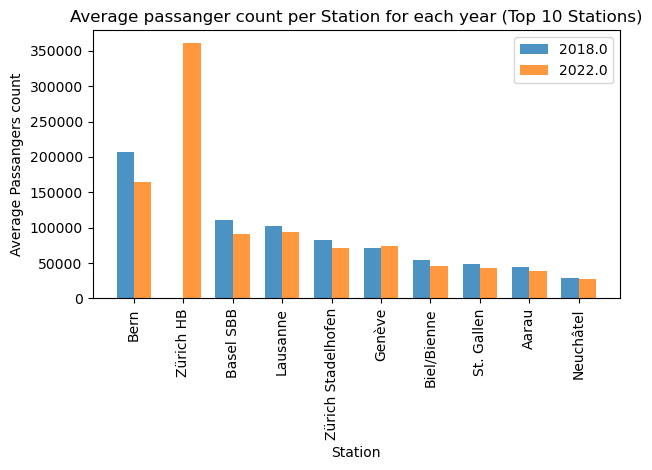

In [ ]:
grouped = (
    passagierfrequenz_df.groupby(["jahr_annee_anno", "bahnhof_gare_stazione"])[
        "dwv_tmjo_tfm"
    ]
    .sum()
    .unstack()
)

# Sort the grouped DataFrame by the sum of 'dtv_tjm_tgm' and select the top 10 'bahnhof_gare_stazione'
top_10_stations = grouped.sum().sort_values(ascending=False).head(10).index
grouped = grouped[top_10_stations]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create the bar chart for each year
bar_width = 0.35
opacity = 0.8

# Create an array with the positions of the bars on the x axis
x_pos = np.arange(len(grouped.columns))

for i, year in enumerate(grouped.index):
    plt.bar(
        x_pos + i * bar_width,
        grouped.loc[year].values,
        bar_width,
        alpha=opacity,
        label=str(year),
    )

# Replace the x ticks with the station names
plt.xticks(x_pos + bar_width / 2, grouped.columns, rotation=90)

plt.xlabel("Station")
plt.ylabel("Average Passangers count")
plt.title("Average passanger count per Station for each year (Top 10 Stations)")
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
def create_bar_chart_avg_passenger_count_per_station(passagierfrequenz_df, save=False):
    grouped = (
        passagierfrequenz_df.groupby(["jahr_annee_anno", "bahnhof_gare_stazione"])[
            "dnwv_tmjno_tmgnl"
        ]
        .sum()
        .unstack()
    )

    # Sort the grouped DataFrame by the sum of 'dnwv_tmjno_tmgnl' and select the top 10 'bahnhof_gare_stazione'
    top_10_stations = grouped.sum().sort_values(ascending=False).head(10).index
    grouped = grouped[top_10_stations]

    # Convert the DataFrame to a format that can be used with seaborn
    df_grouped = pd.melt(
        grouped.reset_index(), id_vars="jahr_annee_anno", value_vars=top_10_stations
    )

    # Convert 'jahr_annee_anno' to string
    df_grouped["jahr_annee_anno"] = df_grouped["jahr_annee_anno"].astype(str)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="value",
        y="bahnhof_gare_stazione",
        hue="jahr_annee_anno",
        data=df_grouped,
        ax=ax,
    )
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Average passenger count per Station for each year (Top 10 Stations)")
    plt.xlabel("Average Passengers count")
    plt.ylabel("Station")
    plt.grid(axis="x")
    plt.xticks(
        np.arange(0, df_grouped["value"].max() + 1, df_grouped["value"].max() // 10)
    )
    plt.legend()

    if save:
        plt.savefig(
            "../figures/exploration/avg_passenger_count_per_station.png",
            bbox_inches="tight",
        )
        plt.close()

In [37]:
create_bar_chart_avg_passenger_count_per_station(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

In [38]:
def create_bar_chart_avg_passenger_count_kantone(passagierfrequenz_df, save=False):
    grouped = (
        passagierfrequenz_df.groupby(["jahr_annee_anno", "kt_ct_cantone"])[
            "dtv_tjm_tgm"
        ]
        .sum()
        .unstack()
    )

    # Sort the grouped DataFrame by the sum of 'dtv_tjm_tgm' and select the top 10 'kt_ct_cantone'
    top_10_kantone = grouped.sum().sort_values(ascending=False).head(10).index
    grouped = grouped[top_10_kantone]

    # Convert the DataFrame to a format that can be used with seaborn
    df_grouped = pd.melt(
        grouped.reset_index(), id_vars="jahr_annee_anno", value_vars=top_10_kantone
    )

    # Convert 'jahr_annee_anno' to string
    df_grouped["jahr_annee_anno"] = df_grouped["jahr_annee_anno"].astype(str)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="value", y="kt_ct_cantone", hue="jahr_annee_anno", data=df_grouped, ax=ax
    )
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Average passenger count per Kantone for each year (Top 10 Kantone)")
    plt.xlabel("Average Passengers count")
    plt.ylabel("Kantone")
    plt.grid(axis="x")
    plt.xticks(
        np.arange(0, df_grouped["value"].max() + 1, df_grouped["value"].max() // 10)
    )
    plt.legend()

    if save:
        plt.savefig(
            "../figures/exploration/avg_passenger_count_kantone.png",
            bbox_inches="tight",
        )
        plt.close()

In [39]:
create_bar_chart_avg_passenger_count_kantone(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

In [40]:
def create_bar_chart_avg_passenger_count_kantone_workweek(
    passagierfrequenz_df, save=False
):
    grouped = (
        passagierfrequenz_df.groupby(["jahr_annee_anno", "kt_ct_cantone"])[
            "dwv_tmjo_tfm"
        ]
        .sum()
        .unstack()
    )

    # Sort the grouped DataFrame by the sum of 'dwv_tmjo_tfm' and select the top 10 'kt_ct_cantone'
    top_10_kantone = grouped.sum().sort_values(ascending=False).head(10).index
    grouped = grouped[top_10_kantone]

    # Convert the DataFrame to a format that can be used with seaborn
    df_grouped = pd.melt(
        grouped.reset_index(), id_vars="jahr_annee_anno", value_vars=top_10_kantone
    )

    # Convert 'jahr_annee_anno' to string
    df_grouped["jahr_annee_anno"] = df_grouped["jahr_annee_anno"].astype(str)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="value", y="kt_ct_cantone", hue="jahr_annee_anno", data=df_grouped, ax=ax
    )
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title(
        "Average passenger count per Kantone for each year. Work week (Top 10 Kantone)"
    )
    plt.xlabel("Average Passengers count")
    plt.ylabel("Kantone")
    plt.grid(axis="x")
    plt.xticks(
        np.arange(0, df_grouped["value"].max() + 1, df_grouped["value"].max() // 10)
    )
    plt.legend()

    if save:
        plt.savefig(
            "../figures/exploration/avg_passenger_count_kantone_workweek.png",
            bbox_inches="tight",
        )
        plt.close()

In [41]:
create_bar_chart_avg_passenger_count_kantone_workweek(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

In [42]:
def create_bar_chart_avg_passenger_count_kantone_nonworkdays(
    passagierfrequenz_df, save=False
):
    grouped = (
        passagierfrequenz_df.groupby(["jahr_annee_anno", "kt_ct_cantone"])[
            "dnwv_tmjno_tmgnl"
        ]
        .sum()
        .unstack()
    )

    # Sort the grouped DataFrame by the sum of 'dnwv_tmjno_tmgnl' and select the top 10 'kt_ct_cantone'
    top_10_kantone = grouped.sum().sort_values(ascending=False).head(10).index
    grouped = grouped[top_10_kantone]

    # Convert the DataFrame to a format that can be used with seaborn
    df_grouped = pd.melt(
        grouped.reset_index(), id_vars="jahr_annee_anno", value_vars=top_10_kantone
    )

    # Convert 'jahr_annee_anno' to string
    df_grouped["jahr_annee_anno"] = df_grouped["jahr_annee_anno"].astype(str)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="value", y="kt_ct_cantone", hue="jahr_annee_anno", data=df_grouped, ax=ax
    )
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title(
        "Average passenger count per Kantone for each year, non-work days (Top 10 Kantone)"
    )
    plt.xlabel("Average Passengers count")
    plt.ylabel("Kantone")
    plt.grid(axis="x")
    plt.xticks(
        np.arange(0, df_grouped["value"].max() + 1, df_grouped["value"].max() // 10)
    )
    plt.legend()

    if save:
        plt.savefig(
            "../figures/exploration/avg_passenger_count_kantone_nonworkdays.png",
            bbox_inches="tight",
        )
        plt.close()

In [49]:
def create_bar_chart_avg_passenger_count_daytype(passagierfrequenz_df, save=False):
    grouped = passagierfrequenz_df.groupby("jahr_annee_anno")[
        ["dtv_tjm_tgm", "dwv_tmjo_tfm", "dnwv_tmjno_tmgnl"]
    ].mean()

    # Convert the DataFrame to a format that can be used with seaborn
    df_grouped = pd.melt(grouped.reset_index(), id_vars="jahr_annee_anno")

    # Convert 'jahr_annee_anno' to string
    df_grouped["jahr_annee_anno"] = df_grouped["jahr_annee_anno"].astype(str)

    # Replace the variable names with more descriptive labels
    df_grouped.replace(
        {
            "dtv_tjm_tgm": "Whole Week",
            "dwv_tmjo_tfm": "Work Week",
            "dnwv_tmjno_tmgnl": "Non-Work Days",
        },
        inplace=True,
    )

    # Create the vertical bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="variable", y="value", data=df_grouped, ax=ax, color="skyblue")
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title(
        "Passenger Count for Whole Week, Work Week, and Non-Work Days for each year"
    )
    plt.ylabel("Average Passengers count")
    plt.xlabel("Type of Day")
    plt.grid(axis="y")
    plt.yticks(
        np.arange(0, df_grouped["value"].max() + 1, df_grouped["value"].max() // 10)
    )
    plt.legend()

    if save:
        plt.savefig(
            "../figures/exploration/avg_passenger_count_daytype.png",
            bbox_inches="tight",
        )
        plt.close()

In [50]:
create_bar_chart_avg_passenger_count_daytype(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [52]:
def create_bar_chart_bahnhofseigner(passagierfrequenz_df, save=False, values=10):
    counts = passagierfrequenz_df["evu_ef_itf"].value_counts()

    if values > len(counts):
        values = len(counts)

    counts = counts.head(values)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
    )
    plt.title("Top {values} Bahnhofseigner")
    plt.xlabel("Bahnhofseigner")
    plt.ylabel("Number of Bahnhöfe")
    plt.grid(axis="y")

    if save:
        plt.savefig(
            "../figures/exploration/bahnhofseigner_count.png", bbox_inches="tight"
        )
        plt.close()

In [53]:
create_bar_chart_bahnhofseigner(passagierfrequenz_df, save=True)

c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tklas\anaconda3\envs\new_base\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Missing Data


In [ ]:
display(fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"].dtypes)

linie                    int64
richtung                 int64
betriebsdatum           object
fahrzeug                 int64
kurs                     int64
seq_von                  int64
halt_diva_von            int64
halt_punkt_diva_von      int64
halt_kurz_von1          object
datum_von               object
soll_an_von              int64
ist_an_von               int64
soll_ab_von              int64
ist_ab_von               int64
seq_nach                 int64
halt_diva_nach           int64
halt_punkt_diva_nach     int64
halt_kurz_nach1         object
datum_nach              object
soll_an_nach             int64
ist_an_nach1             int64
soll_ab_nach             int64
ist_ab_nach              int64
fahrt_id                 int64
fahrweg_id               int64
fw_no                    int64
fw_typ                   int64
fw_kurz                  int64
fw_lang                 object
umlauf_von               int64
halt_id_von              int64
halt_id_nach             int64
halt_pun

In [ ]:
display(fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"].columns)

Index(['linie', 'richtung', 'betriebsdatum', 'fahrzeug', 'kurs', 'seq_von',
       'halt_diva_von', 'halt_punkt_diva_von', 'halt_kurz_von1', 'datum_von',
       'soll_an_von', 'ist_an_von', 'soll_ab_von', 'ist_ab_von', 'seq_nach',
       'halt_diva_nach', 'halt_punkt_diva_nach', 'halt_kurz_nach1',
       'datum_nach', 'soll_an_nach', 'ist_an_nach1', 'soll_ab_nach',
       'ist_ab_nach', 'fahrt_id', 'fahrweg_id', 'fw_no', 'fw_typ', 'fw_kurz',
       'fw_lang', 'umlauf_von', 'halt_id_von', 'halt_id_nach',
       'halt_punkt_id_von', 'halt_punkt_id_nach'],
      dtype='object')

In [ ]:
selected_columns_df = fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"][
    [
        "linie",
        "halt_id_von",
        "halt_punkt_id_von",
        "halt_kurz_von1",
        "seq_von",
        "seq_nach",
    ]
]

display(selected_columns_df.columns)

Index(['linie', 'halt_id_von', 'halt_punkt_id_von', 'halt_kurz_von1',
       'seq_von', 'seq_nach'],
      dtype='object')

In [ ]:
all_haltestellen_df = pd.merge(haltestelle_df, haltepunkt_df, on="halt_id", how="outer")

display(all_haltestellen_df)

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv,halt_punkt_id,halt_punkt_diva,GPS_Latitude,GPS_Longitude,GPS_Bearing,halt_punkt_ist_aktiv
0,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,303,51,47.360017,8.456337,85.0,False
1,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,304,50,47.360153,8.456180,270.0,False
2,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,10982,50,47.360153,8.456180,266.0,False
3,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,13469,51,47.360035,8.456297,85.0,False
4,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,13485,50,47.360154,8.456141,266.0,False
...,...,...,...,...,...,...,...,...,...,...,...
19686,3338,7070,OBER,"Zürich, Obere Hornhalde",True,54979,51,47.331647,8.538054,328.0,True
19687,3339,7065,OGAS,"Oetwil an der Limmat, Gässliacker",True,54811,51,47.429765,8.392162,315.0,True
19688,3339,7065,OGAS,"Oetwil an der Limmat, Gässliacker",True,54820,50,47.429647,8.392346,135.0,True
19689,3360,6923,ZNIE,"Zollikon, Niederhofenrain",True,54815,51,47.347797,8.576690,270.0,True


In [ ]:
# Convert pandas DataFrames to Dask DataFrames
selected_columns_dd = dd.from_pandas(selected_columns_df, npartitions=10)
haltestelle_dd = dd.from_pandas(haltestelle_df, npartitions=10)
haltepunkt_dd = dd.from_pandas(haltepunkt_df, npartitions=10)

# Perform the merge operation
merged_dd = selected_columns_dd.merge(
    haltestelle_dd, left_on="halt_id_von", right_on="halt_id"
)
final_dd = merged_dd.merge(haltepunkt_dd, left_on="halt_id_von", right_on="halt_id")

# Convert Dask DataFrame back to pandas DataFrame
final_df = final_dd.compute()

# Select only the necessary columns
bus_stops_for_each_line_df = final_df[
    [
        "linie",
        "halt_id_von",
        "halt_diva",
        "halt_kurz",
        "GPS_Latitude",
        "GPS_Longitude",
        "seq_von",
        "seq_nach",
    ]
]

In [ ]:
display(bus_stops_for_each_line_df)

bus_stops_for_each_line_df.sort_values(by=["linie"], inplace=True)

display(bus_stops_for_each_line_df)

,linie,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
0,32,2702,498,BIRD,47.407217,8.530893,7,8
1,32,2702,498,BIRD,47.407879,8.530364,7,8
2,32,2702,498,BIRD,47.407882,8.530365,7,8
3,32,2702,498,BIRD,47.407220,8.530895,7,8
4,32,2702,498,BIRD,47.407879,8.530364,7,8
...,...,...,...,...,...,...,...,...
6641128,162,1911,75,ALZE,47.320015,8.540657,6,7
6641129,162,1911,75,ALZE,47.319752,8.540890,6,7
6641130,162,1911,75,ALZE,47.319755,8.540891,6,7
6641131,162,1911,75,ALZE,47.320018,8.540658,6,7


C:\Users\tklas\AppData\Local\Temp\ipykernel_7276\3756124768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_stops_for_each_line_df.sort_values(by=["linie"], inplace=True)


,linie,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
966180,2,1565,440,BELL,47.367749,8.546028,25,26
9772708,2,2245,1548,LETG,47.380951,8.502915,14,15
9772707,2,2245,1548,LETG,47.380863,8.504768,14,15
9772706,2,2245,1548,LETG,47.381626,8.503909,14,15
9772705,2,2245,1548,LETG,47.380951,8.502915,14,15
...,...,...,...,...,...,...,...,...
5286335,919,2780,2038,REBW,47.326670,8.598042,3,4
5286334,919,2780,2038,REBW,47.326472,8.598104,3,4
5286333,919,2780,2038,REBW,47.326667,8.598041,3,4
5286331,919,2780,2038,REBW,47.326472,8.598104,3,4


TraitError: Invalid selection: value not found

,linie,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
0,32,2702,498,BIRD,47.407217,8.530893,7,8
1,32,2702,498,BIRD,47.407879,8.530364,7,8
2,32,2702,498,BIRD,47.407879,8.530364,7,8
3,32,2702,498,BIRD,47.407882,8.530365,7,8
4,32,2702,498,BIRD,47.407220,8.530895,7,8
...,...,...,...,...,...,...,...,...
6641128,162,1911,75,ALZE,47.319755,8.540891,5,6
6641129,162,1911,75,ALZE,47.320018,8.540658,5,6
6641130,162,1911,75,ALZE,47.319755,8.540891,5,6
6641131,162,1911,75,ALZE,47.320018,8.540658,5,6


C:\Users\tklas\AppData\Local\Temp\ipykernel_33256\3756124768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_stops_for_each_line_df.sort_values(by=["linie"], inplace=True)


,linie,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
5485294,2,2505,935,GASO,47.397819,8.460252,28,29
8143223,2,1535,48,ALBP,47.378092,8.509612,12,13
8143222,2,1535,48,ALBP,47.378384,8.510094,12,13
8143221,2,1535,48,ALBP,47.380041,8.507321,12,13
8143220,2,1535,48,ALBP,47.380013,8.507467,12,13
...,...,...,...,...,...,...,...,...
9696538,919,2864,2167,SIHG,47.321455,8.586683,5,6
9696537,919,2864,2167,SIHG,47.321458,8.586684,5,6
9696536,919,2864,2167,SIHG,47.321649,8.586503,5,6
9696534,919,2864,2167,SIHG,47.321458,8.586684,5,6


In [ ]:
# Erstellen Sie eine Karte mit einem Startpunkt (z. B. den geografischen Koordinaten einer Stadt).
m = folium.Map(location=[47, 8], zoom_start=10)

# Erhalten Sie die eindeutigen Werte in der "geopos" Spalte
unique_geopos = passagierfrequenz_df["geopos"].unique()

# Filter out the wrong values
unique_geopos = [geopos for geopos in unique_geopos if type(geopos) == str]

# Fügen Sie Marker für jede eindeutige geopos hinzu
# for geopos in unique_geopos:
#     # Teilen Sie den geopos String in latitude und longitude
#     latitude, longitude = geopos.split(',')

#     folium.Marker(
#         location=[latitude, longitude],
#         icon=folium.Icon(color="red")
#     ).add_to(m)


# haltepunkte_df is a dataframe with all rows from haltepunkt_df where GPS_Latitude and GPS_Longitude are not NaN
haltepunkte_df = haltepunkt_df[
    haltepunkt_df["GPS_Latitude"].notna() & haltepunkt_df["GPS_Longitude"].notna()
]

# Nur die Zeilen, wo eine Unique Komination von GPS_Latitude und GPS_Longitude existiert
haltepunkte_df = haltepunkte_df.drop_duplicates(
    subset=["GPS_Latitude", "GPS_Longitude"]
)

haltepunkte_df = haltepunkte_df.head(10)

locations = []

for index, row in haltepunkte_df.iterrows():
    location = [row["GPS_Latitude"], row["GPS_Longitude"]]
    locations.append(location)
    folium.Marker(location=location, icon=folium.Icon(color="blue")).add_to(m)

# Verbinden Sie die Haltepunkte mit Linien
folium.PolyLine(locations, color="red", weight=2.5, opacity=1).add_to(m)


# folium.TileLayer('Mapbox Bright').add_to(my_map)

Basic Analysis


In [ ]:
display(fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"].dtypes)

linie                    int64
richtung                 int64
betriebsdatum           object
fahrzeug                 int64
kurs                     int64
seq_von                  int64
halt_diva_von            int64
halt_punkt_diva_von      int64
halt_kurz_von1          object
datum_von               object
soll_an_von              int64
ist_an_von               int64
soll_ab_von              int64
ist_ab_von               int64
seq_nach                 int64
halt_diva_nach           int64
halt_punkt_diva_nach     int64
halt_kurz_nach1         object
datum_nach              object
soll_an_nach             int64
ist_an_nach1             int64
soll_ab_nach             int64
ist_ab_nach              int64
fahrt_id                 int64
fahrweg_id               int64
fw_no                    int64
fw_typ                   int64
fw_kurz                  int64
fw_lang                 object
umlauf_von               int64
halt_id_von              int64
halt_id_nach             int64
halt_pun

In [ ]:
display(fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"].columns)

Index(['linie', 'richtung', 'betriebsdatum', 'fahrzeug', 'kurs', 'seq_von',
       'halt_diva_von', 'halt_punkt_diva_von', 'halt_kurz_von1', 'datum_von',
       'soll_an_von', 'ist_an_von', 'soll_ab_von', 'ist_ab_von', 'seq_nach',
       'halt_diva_nach', 'halt_punkt_diva_nach', 'halt_kurz_nach1',
       'datum_nach', 'soll_an_nach', 'ist_an_nach1', 'soll_ab_nach',
       'ist_ab_nach', 'fahrt_id', 'fahrweg_id', 'fw_no', 'fw_typ', 'fw_kurz',
       'fw_lang', 'umlauf_von', 'halt_id_von', 'halt_id_nach',
       'halt_punkt_id_von', 'halt_punkt_id_nach'],
      dtype='object')

In [ ]:
selected_columns_df = fahrzeiten_dfs["Fahrzeiten_SOLL_IST_20220102_20220108.csv"][
    [
        "linie",
        "richtung",
        "halt_id_von",
        "halt_punkt_id_von",
        "halt_kurz_von1",
        "seq_von",
        "seq_nach",
    ]
]

display(selected_columns_df.columns)

Index(['linie', 'richtung', 'halt_id_von', 'halt_punkt_id_von',
       'halt_kurz_von1', 'seq_von', 'seq_nach'],
      dtype='object')

In [ ]:
all_haltestellen_df = pd.merge(haltestelle_df, haltepunkt_df, on="halt_id", how="outer")

display(all_haltestellen_df)

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv,halt_punkt_id,halt_punkt_diva,GPS_Latitude,GPS_Longitude,GPS_Bearing,halt_punkt_ist_aktiv
0,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,303,51,47.360017,8.456337,85.0,False
1,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,304,50,47.360153,8.456180,270.0,False
2,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,10982,50,47.360153,8.456180,266.0,False
3,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,13469,51,47.360035,8.456297,85.0,False
4,143,2570,BirWSL,"Birmensdorf ZH, Sternen/WSL",True,13485,50,47.360154,8.456141,266.0,False
...,...,...,...,...,...,...,...,...,...,...,...
19686,3338,7070,OBER,"Zürich, Obere Hornhalde",True,54979,51,47.331647,8.538054,328.0,True
19687,3339,7065,OGAS,"Oetwil an der Limmat, Gässliacker",True,54811,51,47.429765,8.392162,315.0,True
19688,3339,7065,OGAS,"Oetwil an der Limmat, Gässliacker",True,54820,50,47.429647,8.392346,135.0,True
19689,3360,6923,ZNIE,"Zollikon, Niederhofenrain",True,54815,51,47.347797,8.576690,270.0,True


In [ ]:
# Convert pandas DataFrames to Dask DataFrames
selected_columns_dd = dd.from_pandas(selected_columns_df, npartitions=10)
haltestelle_dd = dd.from_pandas(haltestelle_df, npartitions=10)
haltepunkt_dd = dd.from_pandas(haltepunkt_df, npartitions=10)

# Perform the merge operation
merged_dd = selected_columns_dd.merge(
    haltestelle_dd, left_on="halt_id_von", right_on="halt_id"
)
final_dd = merged_dd.merge(haltepunkt_dd, left_on="halt_id_von", right_on="halt_id")

# Convert Dask DataFrame back to pandas DataFrame
final_df = final_dd.compute()

# Select only the necessary columns
bus_stops_for_each_line_df = final_df[
    [
        "linie",
        "richtung",
        "halt_id_von",
        "halt_diva",
        "halt_kurz",
        "GPS_Latitude",
        "GPS_Longitude",
        "seq_von",
        "seq_nach",
    ]
]

In [ ]:
display(bus_stops_for_each_line_df)


bus_stops_for_each_line_df = bus_stops_for_each_line_df.dropna(subset=["halt_diva"])

bus_stops_for_each_line_df = bus_stops_for_each_line_df.dropna(
    subset=["GPS_Latitude", "GPS_Longitude"]
)

bus_stops_for_each_line_df.sort_values(by=["linie"], inplace=True)


display(bus_stops_for_each_line_df)

,linie,richtung,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
0,32,1,2756,3029,HSBB,47.386308,8.517975,13,14
1,32,1,2756,3029,HSBB,NaN,NaN,13,14
2,32,1,2756,3029,HSBB,47.385184,8.516973,13,14
3,32,1,2756,3029,HSBB,47.386570,8.518749,13,14
4,32,1,2756,3029,HSBB,47.385343,8.517267,13,14
...,...,...,...,...,...,...,...,...,...
6641128,162,2,1911,75,ALZE,47.320015,8.540657,5,6
6641129,162,2,1911,75,ALZE,47.319752,8.540890,5,6
6641130,162,2,1911,75,ALZE,47.319755,8.540891,5,6
6641131,162,2,1911,75,ALZE,47.320018,8.540658,5,6


,linie,richtung,halt_id_von,halt_diva,halt_kurz,GPS_Latitude,GPS_Longitude,seq_von,seq_nach
1646182,2,2,1565,440,BELL,47.366942,8.545467,8,9
1545068,2,1,1565,440,BELL,47.366453,8.546133,25,26
1545067,2,1,1565,440,BELL,47.366697,8.546006,25,26
1545066,2,1,1565,440,BELL,47.367985,8.544854,25,26
1545065,2,1,1565,440,BELL,47.366582,8.544904,25,26
...,...,...,...,...,...,...,...,...,...
5382653,919,1,2096,2826,WALT,47.336093,8.617990,12,13
5382652,919,1,2096,2826,WALT,47.336109,8.618149,12,13
5382651,919,1,2096,2826,WALT,47.336090,8.617988,12,13
5382621,919,1,2096,2826,WALT,47.336090,8.617988,12,13


In [ ]:
# Dropdown widget with unique line names
dropdown = widgets.Dropdown(
    options=sorted(
        bus_stops_for_each_line_df["linie"].unique()
    ),  # sort the unique line names
    description="Lines:",
)

# Button widget
button = widgets.Button(description="Show Map")


# Function to be called when the button is clicked
def on_button_clicked(b):
    # Filter DataFrame for selected line
    df = bus_stops_for_each_line_df[
        bus_stops_for_each_line_df["linie"] == dropdown.value
    ]  # replace 'linie' with your column name

    # Sort the DataFrame by 'sq_von'
    df = df.sort_values(by="seq_von")

    display(df)

    # Create a map centered at the mean latitude and longitude values
    m = folium.Map(
        location=[df["GPS_Latitude"].mean(), df["GPS_Longitude"].mean()], zoom_start=13
    )

    # Add a marker for each bus stop
    locations = []
    for _, row in df.iterrows():
        location = [row["GPS_Latitude"], row["GPS_Longitude"]]
        locations.append(location)
        folium.Marker(location).add_to(m)

    # Connect the markers with line
    folium.PolyLine(locations, color="red", weight=2.5, opacity=1).add_to(m)

    # Display map
    display(m)


# Link button
button.on_click(on_button_clicked)

# Display widgets
display(dropdown, button)

Dropdown(description='Lines:', options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 31, 32, 33, 35, 37, 38…

Button(description='Show Map', style=ButtonStyle())

TO DO:

- fundamentals für Haltepunkt, Haltestelle und Passagierf

- Geojson in thing
